# Discrete gradients

This notebook contains custom implementation of basic ideas in the article [Few-Bit Backward: Quantized Gradients of Activation Functions for Memory Footprint Reduction](https://arxiv.org/pdf/2202.00441.pdf).

In this notebook you can find calculation of optimal piecewise-constant approximation, and how to fine-tune result with gradient descent.

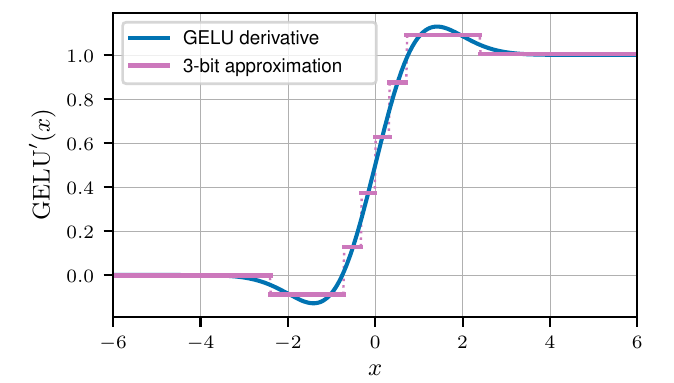

In [170]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy import integrate
from scipy.special import erf
from tqdm import tqdm
from typing import Callable, Any, Tuple, List, Optional

Let's take some activation function for testing

In [217]:
def uniform_weight(x):
    return np.float64((-10 < x) & (x < 10))

In [104]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

In [105]:
def activation(x):
    return sigmoid(x)

In [106]:
def activation_derivative(x):
    s = sigmoid(x)
    return s * (1.0 - s)

# Dynamic programming

In [220]:
def plot_piecewise_constant_function(f: Callable, 
                                     roi: Tuple[float, float],
                                     s_values: 'np.array', y_values: 'np.array',
                                     s_values_new: Optional['np.array']=None,
                                     y_values_new: Optional['np.array']=None) -> None:
    """
    Plots piecewise constant function and original function.
    
    Params
    ------
    f
        original function
    roi : tuple of floats (A, B)
        region of interest for function values. I.e. (-10.0, 10.0)
    s_values : np.array
        Contains segment borders. Always should be s_values[0] == roi[0] and s_values[-1] == roi[1]
        
        so the segments are (s_values[0], s_values[1]), (s_values[1], s_values[2]) ... 
    y_values : np.array
        array of segment values. len(y_values) == len(s_values) - 1
    s_values_new, y_values_new : np.array
        If provided, acts the same way. You can use this for comparison
        
    """
    xs = np.linspace(roi[0], roi[1], 101)
    
    plt.figure(figsize=(10, 4))
    plt.plot(xs, f(xs), label='f\'')
    for i in range(len(y_values)):
        plt.plot([s_values[i], s_values[i + 1]], [y_values[i], y_values[i]], color='black', marker='o', markersize=3)
    if s_values_new is not None and y_values_new is not None:
        for i in range(len(y_values_new)):
            plt.plot([s_values_new[i], s_values_new[i + 1]], 
                     [y_values_new[i], y_values_new[i]], color='blue', marker='o', markersize=3)

    plt.grid()
    plt.legend()
    plt.show()

In [203]:
def precalculate_integrals(derivative_f: Callable, 
                           weight_f : Callable, 
                           roi: Tuple[float, float], 
                           dp_discretisation: int=100) -> Tuple['np.array', 'np.array', 'np.array']:
    """
    Precalculates integrals for fast dynamic programming calculation. The name of
    variables refers to paper
    
    Params
    ------
    derivative_f
        function which calculates f'(x)
    weight_f
        weight function reflecting our prior knowledge of the activation function
        argument distribution
    roi : tuple of floats (A, B)
        region of interest for function values. I.e. (-10.0, 10.0)
    dp_discretisation : int
        Number of samples of x in dynamic programming. Higher value results in
        more accurate approximations, but slows down calculations. Default is 100.
        
    Returns
    -------
    F_2 : np.array
        antiderivative from A to t_i of f'(x)^2 w(x)
    W : np.array
        antiderivative from A to t_i of w(x)
    FW : np.array
        antiderivative from A to t_i of f'(x) w(x)
    """
    A, B = roi
    
    ts = np.linspace(A, B, dp_discretisation)
    
    def function_f_prime_2_w(x):
        return weight_f(x) * derivative_f(x) ** 2
    
    def function_f_prime_w(x):
        return weight_f(x) * derivative_f(x)
    
    F_2 = np.zeros(dp_discretisation, dtype=np.float64)
    W = np.zeros(dp_discretisation, dtype=np.float64)
    FW = np.zeros(dp_discretisation, dtype=np.float64)
    for i in range(1, dp_discretisation):
        F_2[i] = integrate.quad(function_f_prime_2_w, A, ts[i])[0]
        FW [i] = integrate.quad(function_f_prime_w, A, ts[i])[0]
        W  [i] = integrate.quad(weight_f, A, ts[i])[0]
    
    return F_2, W, FW

In [204]:
def restore_s_indices_by_backward_links(backward_links: 'np.ndarray') -> List[int]:
    """
    Restores sequence of indices of answer in dynamic programming. If segments 
    are defined by [A, t_1, t_2, ... t_{n-1}, B], then backward link matrix 
    contains links to previous best segments at every position.
    
    Params
    ------
    backward_links
        np.ndarray of shape [K, N], where K is amount of discretisation
        points (i.e. for 3 bits K = 2**3 - 1 = 7), and N is dp_discretisation + 1
    
    Returns
    -------
    s_indices
        list of indicces
    """
    k, n = backward_links.shape
    s_indices = []
    s_iter = backward_links[-1, -1]
    for k in range(k, -1, -1):
        s_indices.append(s_iter)
        s_iter = backward_links[k - 1, s_iter]
    
    s_indices = list(sorted(s_indices + [0, n - 1]))
    return s_indices

In [232]:
def dynamic_programming(derivative_f : Callable, weight_f : Callable, 
                        roi: Tuple[float, float],
                        n_discretisation: int=8, 
                        dp_discretisation: int=100, 
                        verbose: bool=False) -> Tuple['np.array', 'np.array']:
    """
    Calculates first approximation for piecewise-constant approximation. For details
    please refer to paper https://arxiv.org/pdf/2202.00441.pdf
    
    Params
    ------
    derivative_f
        function for which you need to calculate the discretization
    weight_f
        weight function reflecting our prior knowledge of the activation function
        argument distribution
    roi : tuple of floats (A, B)
        region of interest for function values. I.e. (-10.0, 10.0).
        Interval (roi[0], roi[1]) will be divided into `n_discretisation` + 1 segments 
        of equal length.
    n_discretisation : int
        amount of discretisation points (i.e. for 3 bits n = 2**3 - 1 = 7).
    dp_discretisation : int
        Number of samples of x in dynamic programming. Higher value results in
        more accurate approximations, but slows down calculations. Default is 100.
    verbose : bool
        If True, displays plot of original and approximated function
    
    Returns
    -------
    s_values : np.array
        segmentations borders in format [A, t_1, ..., t_{k-1}, B]
    y_values : np.array
        array of segment values. len(y_values) == len(s_values) - 1
    """
    
    A, B = roi
    ts = np.linspace(A, B, dp_discretisation)
    F_2, W, FW = precalculate_integrals(derivative_f, weight_f, roi, dp_discretisation)
        
    # dynamic programming -----------------------------------------

    # Initialise dynamics with values of T_i_A
    div1 = (FW - FW[0]) ** 2 
    div2 = (W - W[0])
    part1 = np.divide(div1, div2, out=np.zeros_like(div1), where=np.abs(div2)>1e-100) 
    T_A_B = (F_2 - F_2[0] + FW - FW[0] - 2 * part1)
    
    # Warning, there is an typo in the article in the formula (8)!

    # We do not neet full DP matrix, so we just keep current and previous row
    DP = np.full(dp_discretisation, np.inf, dtype=np.float64)
    DP_prev = np.full(dp_discretisation, T_A_B, dtype=np.float64)
    
    backward_links = np.zeros((n_discretisation, dp_discretisation), dtype=np.int32)
    for k in tqdm(range(n_discretisation)):       
        for i in range(dp_discretisation):
            for j in range(i):
                div1 = (FW[i] - FW[j]) ** 2 
                div2 = (W[i] - W[j])
                part1 = div1 / div2 if np.abs(div2) > 1e-50 else 0.0
                T_j_i = (F_2[i] - F_2[j] + FW[i] - FW[j] - 2 * part1)

                new_value = DP_prev[j] + T_j_i
                if new_value < DP[i]:
                    DP[i] = new_value
                    backward_links[k, i] = j

        DP_prev = DP.copy() 
        DP = np.full(dp_discretisation, np.inf, dtype=np.float64)
    
    # restoring piecewise s and y values -----------------------------------------
    
    s_indices = restore_s_indices_by_backward_links(backward_links)
    y_values = (FW[s_indices[1:]] - FW[s_indices[:-1]]) / (W[s_indices[1:]] - W[s_indices[:-1]])
    s_values = ts[s_indices]
    
    if verbose:
        plot_piecewise_constant_function(derivative_f, roi, s_values, y_values)
        
    return s_values, y_values 

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 75.94it/s]


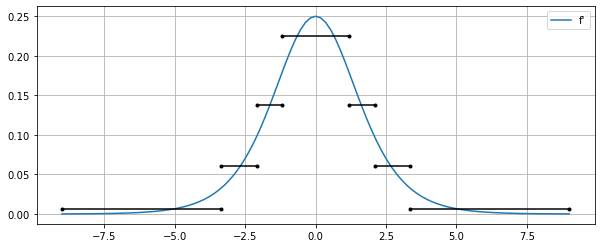

In [233]:
s_init, y_init = dynamic_programming(activation_derivative, uniform_weight, roi=(-9, 9),
       n_discretisation=5, dp_discretisation=100, verbose=True)

# Gradient optimizing fine-tuning

In [234]:
def gradient_optimization_finetune(derivative_f : Callable,
                                   weight_f: Callable,
                                   roi: Tuple[float, float],
                                   s_init: 'np.array', 
                                   y_init: 'np.array',
                                   n_iters: int=50, 
                                   learning_rate: float=2.0,
                                   verbose: bool=False):
    """
    Second part of finding piecewise-constant approximation proposed in the
    article. The minimization problem has many local minima that are far from optimal,
    so it is better to provide good starting approximation.
    
    Params
    ------
    derivative_f
        function for which you need to calculate the discretization
    weight_f
        weight function reflecting our prior knowledge of the activation function
        argument distribution
    roi : tuple of floats (A, B)
        region of interest for function values. I.e. (-10.0, 10.0).
    s_init : np.array
        Initial s approximation. Segmentations borders in format [A, t_1, ..., t_{k-1}, B]
    y_init : np.array
        Initial y approximation. Array of segment values. len(y_values) == len(s_values) - 1
    n_iters : int
        number of gradient descent steps. Default is 50.
    learning_rate : float
        gradient step size. Default is 10.0
    verbose : bool
        If True, plots comparison piecewise-constant approximations before and
        after gradient descent fine-tuning.
        
    Returns
    -------
    
    """
    
    n = len(s_init)
    
    A, B = roi
    def function_f_prime_2_w(x):
        return weight_f(x) * derivative_f(x) ** 2
    
    def function_f_prime_w(x):
        return weight_f(x) * derivative_f(x)
            
    s_values = s_init.copy()
    for i in range(n_iters):
        W = np.zeros(n, dtype=np.float64)
        FW = np.zeros(n, dtype=np.float64)
        for i in range(n):
            FW[i] = integrate.quad(function_f_prime_w, A, s_values[i])[0]
            W[i]  = integrate.quad(weight_f, A, s_values[i])[0]
        
        y_values = (FW[1:] - FW[:-1]) / (W[1:] - W[:-1])
        y = y_values[1:]
        y_prev = y_values[:-1]
        
        # according to the article
        grad = (2 * derivative_f(s_values[1:-1]) - y - y_prev) * \
            (y - y_prev) * weight_f(s_values[1:-1])
        
        s_values[1:-1] = s_values[1:-1] - learning_rate * grad
    
    if verbose:
        plot_piecewise_constant_function(derivative_f, roi, s_init, y_init, s_values, y_values)
    
    return s_values, y_values

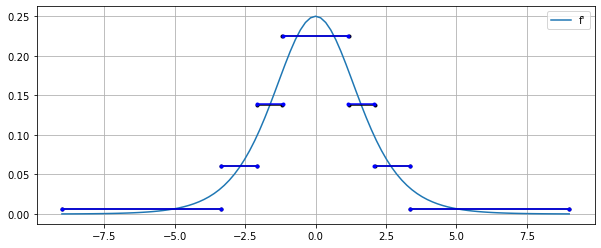

In [235]:
s_finetune, y_finetune = gradient_optimization_finetune(
    activation_derivative, uniform_weight, (-9, 9), s_init, y_init, n_iters=100, verbose=True,
)

Loss is defined by 
$$L(s, y) = \int_{\mathbb{R}}(f^\prime(x)-q(x|s,y))^2 w(x)dx$$

$$q(x|s,y)=\sum_i y_i \mathbb{1}[x \in [s_i; s_{i+1}]]$$

In [236]:
def calculate_loss(derivative_f : Callable, 
                   weight_f : Callable,
                   roi: Tuple[float, float],
                   s_values: 'np.array', 
                   y_values: 'np.array') -> float:
    
    def for_integration(y_i):
        def for_integration_wrapper(x):
            return (derivative_f(x) - y_i) ** 2 * weight_f(x)
        return for_integration_wrapper
    
    loss = 0.0
    for i in range(len(y_values)):
        loss += integrate.quad(for_integration(y_values[i]), s_values[i], s_values[i + 1])[0]
        
    return loss    

In [237]:
loss_DP = calculate_loss(activation_derivative, weight_function, (-9, 9), s_init, y_init)
loss_FT = calculate_loss(activation_derivative, weight_function, (-9, 9), s_finetune, y_finetune)

In [238]:
print('Loss with dynamic programming  :', loss_DP)
print('Loss with gradient fine-tuning :', loss_FT)

Loss with dynamic programming  : 0.003746519826995076
Loss with gradient fine-tuning : 0.0037321047239769734


# Playing with functions

Now let's try other parameters and functions!

In [239]:
def plot_multiple_discretisations(derivative_f : Callable,
                                  weight_f : Callable,
                                  roi: Tuple[float, float]) -> None:
    for k in [4-1, 8-1, 50-1]:
        s_init, y_init = dynamic_programming(
            derivative_f, weight_f, 
            roi=roi, n_discretisation=k, dp_discretisation=500
        )
        s_finetune, y_finetune = gradient_optimization_finetune(
            derivative_f, weight_f, roi, s_init, y_init, verbose=True
        )
        loss_DP = calculate_loss(derivative_f, weight_f, (-9, 9), s_init, y_init)
        loss_FT = calculate_loss(derivative_f, weight_f, (-9, 9), s_finetune, y_finetune)
        print('Loss with dynamic programming  :', loss_DP)
        print('Loss with gradient fine-tuning :', loss_FT)

#### sigmoid

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.28it/s]


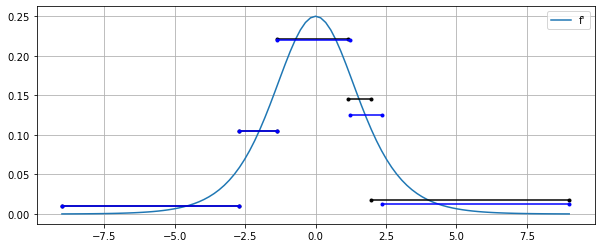

Loss with dynamic programming  : 0.009195959645506045
Loss with gradient fine-tuning : 0.007469199664329202


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.22it/s]


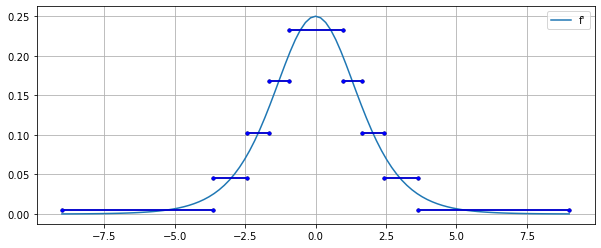

Loss with dynamic programming  : 0.00231039094224695
Loss with gradient fine-tuning : 0.0023100054251594263


100%|███████████████████████████████████████████| 49/49 [00:14<00:00,  3.29it/s]


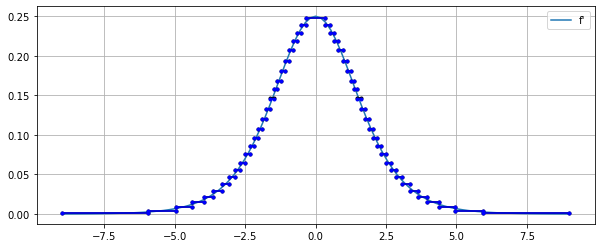

Loss with dynamic programming  : 8.019255327001926e-05
Loss with gradient fine-tuning : 7.99996894500905e-05


In [240]:
plot_multiple_discretisations(activation_derivative, uniform_weight, (-9.0, 9.0))

#### GELU

In [241]:
# https://alaaalatif.github.io/2019-04-11-gelu/

def phi(x):
    return 0.5 * (1.0 + erf(x / np.sqrt(2.0)))

def normal_pdf(x):
    return 1.0 / np.sqrt(2.0 * np.pi) * np.exp(-0.5 * x**2)

def gelu_derivative(x):
    return phi(x) + x * normal_pdf(x)

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.24it/s]


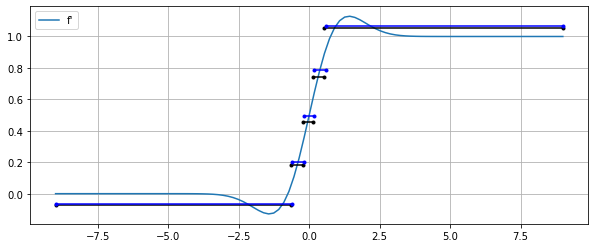

Loss with dynamic programming  : 0.0051072853578070145
Loss with gradient fine-tuning : 0.004953089121983923


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.23it/s]


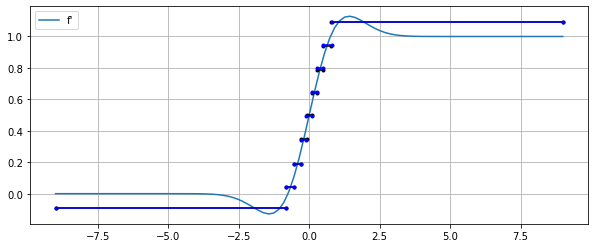

Loss with dynamic programming  : 0.0015474748407324002
Loss with gradient fine-tuning : 0.0015299529797547105


100%|███████████████████████████████████████████| 49/49 [00:15<00:00,  3.25it/s]


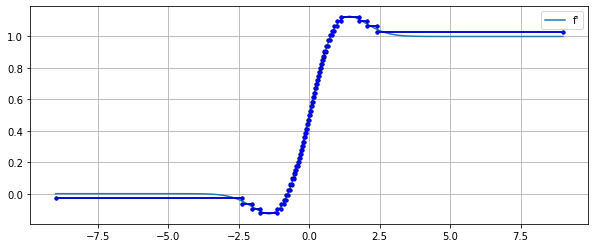

Loss with dynamic programming  : 6.807922956560361e-05
Loss with gradient fine-tuning : 6.648981504253844e-05


In [242]:
plot_multiple_discretisations(gelu_derivative, normal_pdf, (-9.0, 9.0))

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.23it/s]


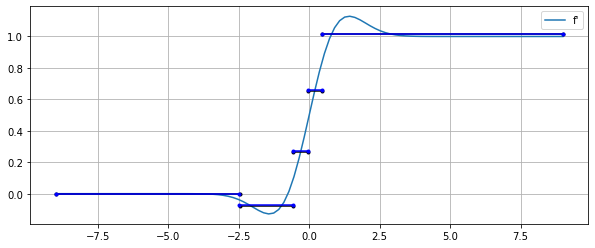

Loss with dynamic programming  : 0.03292906354314509
Loss with gradient fine-tuning : 0.032916931839990955


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.20it/s]


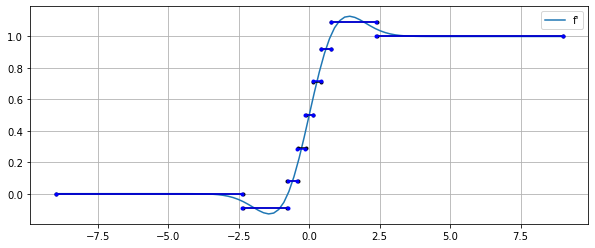

Loss with dynamic programming  : 0.009213443053287302
Loss with gradient fine-tuning : 0.009172527595171457


100%|███████████████████████████████████████████| 49/49 [00:15<00:00,  3.25it/s]


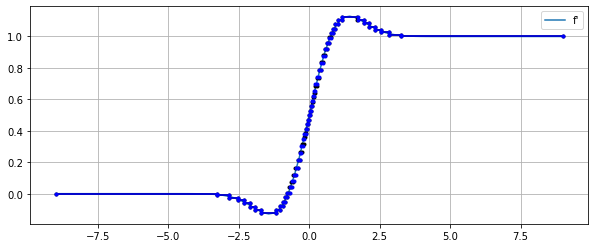

Loss with dynamic programming  : 0.00037555840016083113
Loss with gradient fine-tuning : 0.0003555942770250597


In [243]:
plot_multiple_discretisations(gelu_derivative, uniform_weight, (-9.0, 9.0))

#### SELU

In [244]:
def selu_derivative(alpha=1.0, scale=1.0):
    def selu_wrapper(x):
        return np.float32(x > 0) * alpha + np.float32(x <= 0) * alpha * scale * np.exp(x)
    return selu_wrapper

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.24it/s]


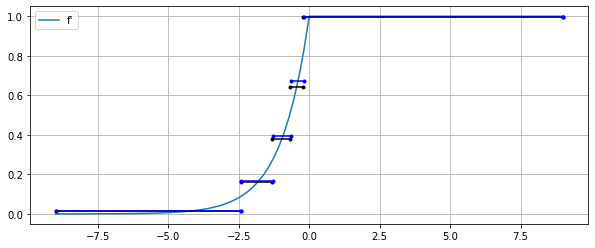

Loss with dynamic programming  : 0.015194882810083826
Loss with gradient fine-tuning : 0.014665873317000143


100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.25it/s]


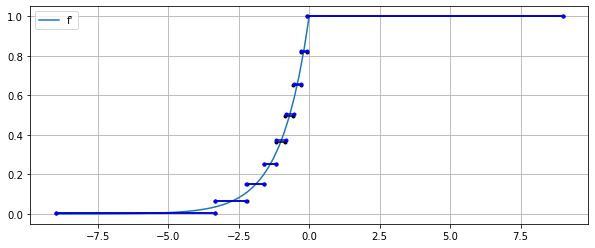

Loss with dynamic programming  : 0.00399385608680331
Loss with gradient fine-tuning : 0.003974142795639629


100%|███████████████████████████████████████████| 49/49 [00:15<00:00,  3.23it/s]


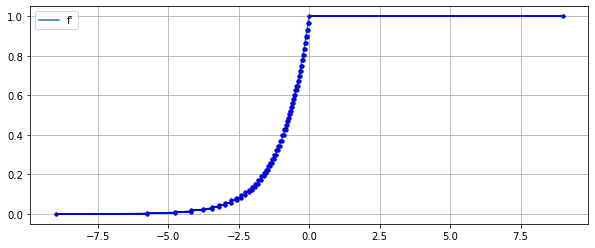

Loss with dynamic programming  : 0.00011497168782210246
Loss with gradient fine-tuning : 0.000113131769562401


In [245]:
plot_multiple_discretisations(selu_derivative(), uniform_weight, (-9.0, 9.0))